In [ ]:
import sys
sys.path.append(r"C:/Users/EXCALIBUR/Desktop")  

from model import AttentionUNet  


In [ ]:
import torch
import numpy as np
from PIL import Image
from sklearn.metrics import f1_score, jaccard_score, precision_score, recall_score
from torchvision import transforms
from tqdm import tqdm
from pathlib import Path
from model import AttentionUNet  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

img_dir = Path(r"C:/Users/EXCALIBUR/Desktop/project/data/combined/test/images")
mask_dir = Path(r"C:/Users/EXCALIBUR/Desktop/project/data/combined/test/masks")

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

from PIL import Image

def preprocess_mask(mask):
    mask = mask.resize((256, 256), Image.NEAREST)  
    mask_np = np.array(mask)
    binary_mask = (mask_np[:, :, 0] > 10).astype(np.float32)
    return torch.tensor(binary_mask).unsqueeze(0)


image_files = sorted(list(img_dir.glob("*.png")))
mask_files = sorted(list(mask_dir.glob("*.png")))

model = AttentionUNet().to(device)
model_path = r"C:/Users/EXCALIBUR/Desktop/project/KOMPLEXPROJEattention_unet_model.pth"
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

all_preds = []
all_masks = []

for img_path, mask_path in tqdm(zip(image_files, mask_files), total=len(image_files), desc="Evaluating"):
    image = Image.open(img_path).convert("RGB")
    mask = Image.open(mask_path).convert("RGB")

    img_tensor = transform(image).unsqueeze(0).to(device)
    mask_tensor = preprocess_mask(mask).to(device)

    with torch.no_grad():
        output = model(img_tensor)
        pred = (output > 0.0002).float()

    all_preds.append(pred.cpu().numpy().reshape(-1))
    all_masks.append(mask_tensor.cpu().numpy().reshape(-1))

y_true = np.vstack(all_masks)
y_pred = np.vstack(all_preds)

iou = jaccard_score(y_true, y_pred, average='samples')
f1 = f1_score(y_true, y_pred, average='samples')
precision = precision_score(y_true, y_pred, average='samples')
recall = recall_score(y_true, y_pred, average='samples')
pixel_acc = (y_true == y_pred).mean()

print("📌 Test Set Metrics:")
print(f"IoU (Jaccard):   {iou:.4f}")
print(f"F1 Score:        {f1:.4f}")
print(f"Precision:       {precision:.4f}")
print(f"Recall:          {recall:.4f}")
print(f"Pixel Accuracy:  {pixel_acc:.4f}")


C:\Users\EXCALIBUR\AppData\Local\Temp\ipykernel_6552\1353917660.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_locatio

📌 Test Set Metrics:
IoU (Jaccard):   0.8041
F1 Score:        0.8874
Precision:       0.8116
Recall:          0.9870
Pixel Accuracy:  0.9803


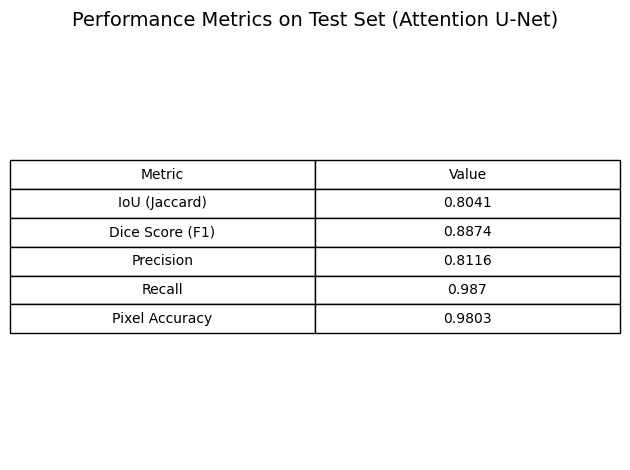

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

data = {
    "Metric": ["IoU (Jaccard)", "Dice Score (F1)", "Precision", "Recall", "Pixel Accuracy"],
    "Value": [0.8041, 0.8874, 0.8116, 0.9870, 0.9803]
}
df = pd.DataFrame(data)

fig, ax = plt.subplots()
ax.axis('off')
table = ax.table(cellText=df.values, colLabels=df.columns, loc='center', cellLoc='center')
table.scale(1, 1.5)
plt.title("Performance Metrics on Test Set (Attention U-Net)", fontsize=14)
plt.tight_layout()
plt.savefig("performance_metrics_table.png", dpi=300)
plt.show()
